# Install Evidently and DVC with DVCLive

Run on Google Colab

In [1]:
!pip uninstall -q -y sqlalchemy pyarrow ipython-sql pandas-gbq

In [2]:
%%capture
!pip install -q dvc==3.25.0 dvclive==3.0.1 evidently==0.4.5 pandas==1.5.3

# Load the data

In [3]:
!mkdir raw_data && \
 cd raw_data && \
 wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip && \
 unzip bike+sharing+dataset.zip

--2023-10-16 14:55:29--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [   <=>              ] 273.43K   443KB/s    in 0.6s    

2023-10-16 14:55:30 (443 KB/s) - ‘bike+sharing+dataset.zip’ saved [279992]

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("raw_data/day.csv", header=0, sep=',', parse_dates=['dteday'])
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Define column mapping

In [6]:
from evidently.pipeline.column_mapping import ColumnMapping

In [7]:
data_columns = ColumnMapping()
data_columns.numerical_features = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed']
data_columns.categorical_features = ['holiday', 'workingday']

# Define what to log

In [8]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [9]:
def eval_drift(reference, production, column_mapping):
    data_drift_report = Report(metrics=[DataDriftPreset()])
    data_drift_report.run(
        reference_data=reference, current_data=production, column_mapping=column_mapping
    )
    report = data_drift_report.as_dict()

    drifts = []

    for feature in (
        column_mapping.numerical_features + column_mapping.categorical_features
    ):
        drifts.append(
            (
                feature,
                report["metrics"][1]["result"]["drift_by_columns"][feature][
                    "drift_score"
                ],
            )
        )

    return drifts


# Define the comparison windows

In [10]:
#set reference dates
reference_dates = ('2011-01-01 00:00:00','2011-01-28 23:00:00')

#set experiment batches dates
experiment_batches = [
    ('2011-01-01 00:00:00','2011-01-29 23:00:00'),
    ('2011-01-29 00:00:00','2011-02-07 23:00:00'),
    ('2011-02-07 00:00:00','2011-02-14 23:00:00'),
    ('2011-02-15 00:00:00','2011-02-21 23:00:00'),
]

# Run and log experiments with DVCLive

In [11]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

In [12]:
from dvclive import Live

There are two ways to use DVC, put all the drift evaluation steps in one single experiment (corresponding to a git commit), or to save each step as a separate experiment (git commit)

## In one experiment

In [13]:
# Setup a git repo with dvc

%cd /content
!rm -rf experiments && mkdir experiments
%cd experiments

!git init
!git add .gitignore
!git commit -m "Init repo"
!dvc init
!git commit -m "Init DVC"

/content
/content/experiments
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/experiments/.git/
fatal: pathspec '.gitignore' did not match any files
On branch master

Initial commit

nothing to commit (create/copy files and use "git add" to track)
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analyt

# DVC Report

params.yaml

| begin               | end                 |
|---------------------|---------------------|
| 2011-02-15 00:00:00 | 2011-02-21 23:00:00 |

metrics.json

|   weathersit |   temp |   atemp |   hum |   windspeed |   holiday |   workingday |   step |
|--------------|--------|---------|-------|-------------|-----------|--------------|--------|
|        0.231 |      0 |       0 | 0.062 |       0.012 |     0.275 |        0.593 |      3 |

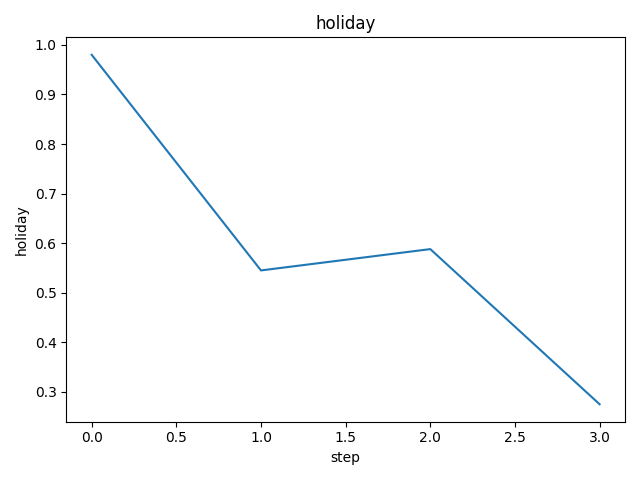

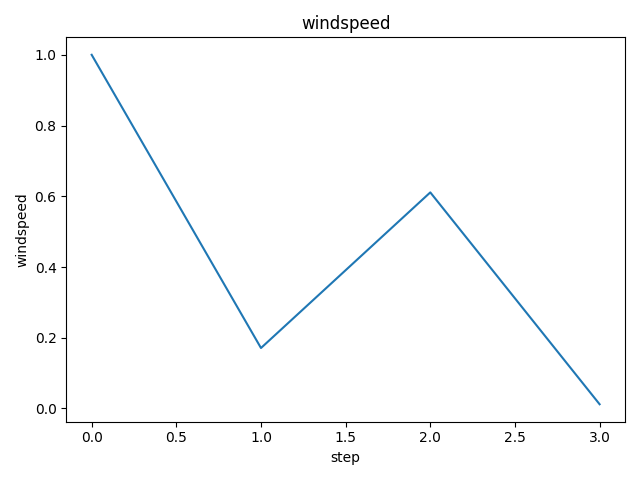

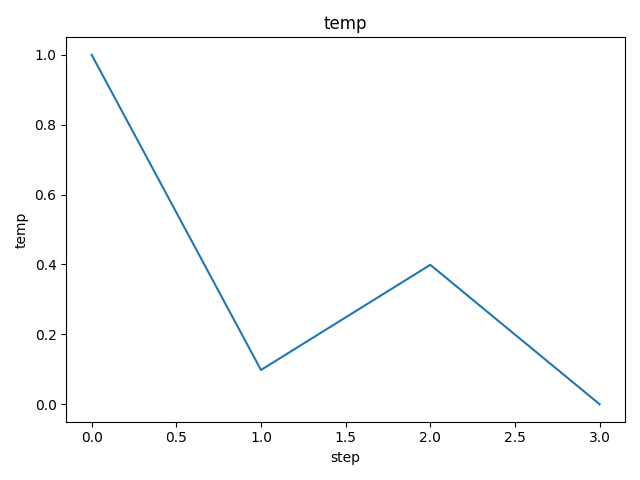

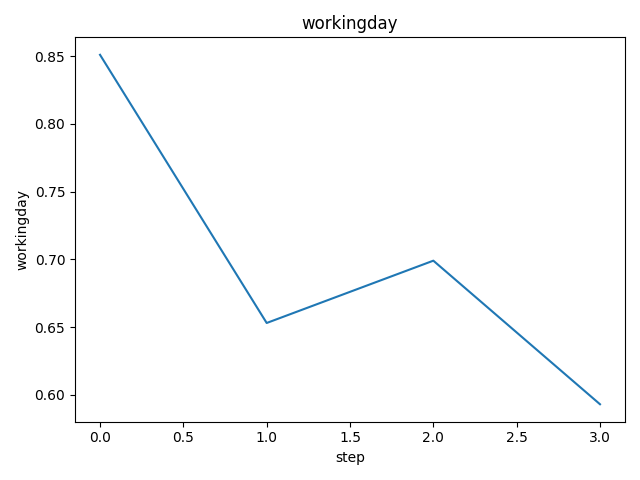

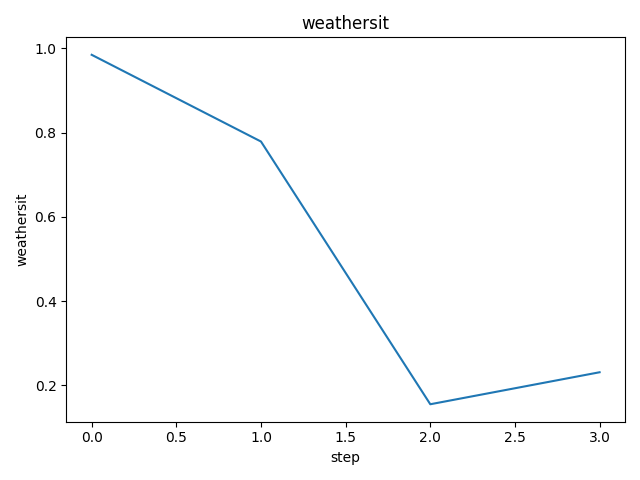

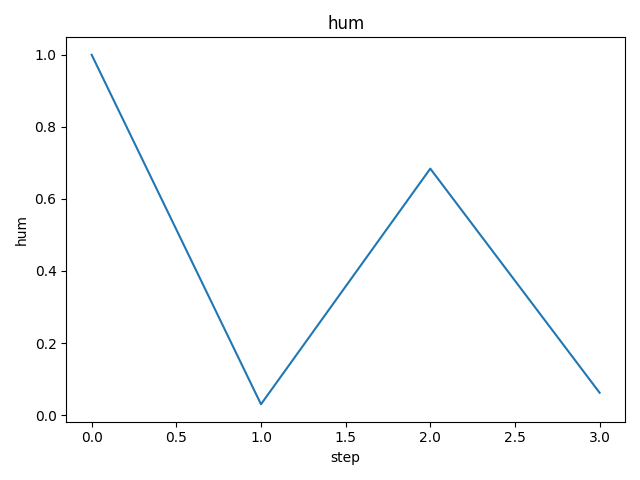

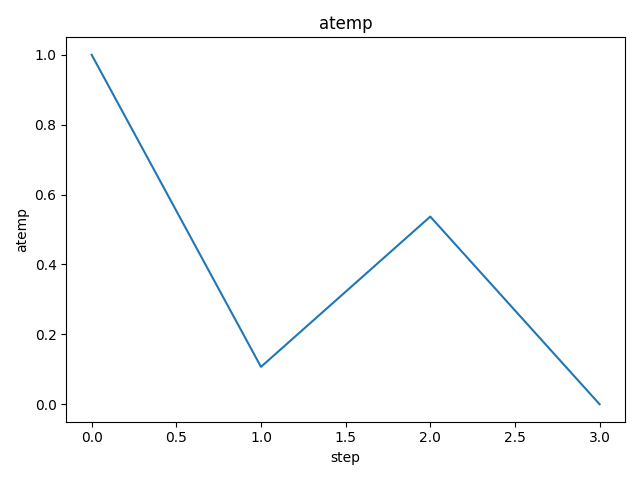


In [14]:
with Live(report="notebook") as live:
    for date in experiment_batches:
        live.log_param("begin", date[0])
        live.log_param("end", date[1])

        metrics = eval_drift(
            df.loc[df.dteday.between(reference_dates[0], reference_dates[1])],
            df.loc[df.dteday.between(date[0], date[1])],
            column_mapping=data_columns,
        )

        for feature in metrics:
            live.log_metric(feature[0], round(feature[1], 3))

        live.next_step()

To explore the results from CLI:

In [15]:
!dvc plots show

file:///content/experiments/dvc_plots/index.html


In [16]:
import IPython
IPython.display.HTML(filename='dvc_plots/index.html')

## In multiple experiments (one per step)

In [17]:
# Setup a git repo with dvc

%cd /content
!rm -rf experiments && mkdir experiments
%cd experiments

!git init
!git add .gitignore
!git commit -m "Init repo"
!dvc init
!git commit -m "Init DVC"

/content
/content/experiments
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/experiments/.git/
fatal: pathspec '.gitignore' did not match any files
On branch master

Initial commit

nothing to commit (create/copy files and use "git add" to track)
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analyt

In [18]:
from dvclive import Live

for step, date in enumerate(experiment_batches):
    with Live() as live:
        live.log_param("step", step)
        live.log_param("begin", date[0])
        live.log_param("end", date[1])

        metrics = eval_drift(
            df.loc[df.dteday.between(reference_dates[0], reference_dates[1])],
            df.loc[df.dteday.between(date[0], date[1])],
            column_mapping=data_columns,
        )

        for feature in metrics:
            live.log_metric(feature[0], round(feature[1], 3))


In [19]:
import dvc.api

pd.DataFrame(dvc.api.exp_show())

,Experiment,rev,typ,Created,parent,State,Executor,weathersit,temp,atemp,hum,windspeed,holiday,workingday,step,begin,end
0,None,workspace,baseline,None,None,None,None,0.231,NaN,NaN,0.062,0.012,0.275,0.593,3.0,2011-02-15 00:00:00,2011-02-21 23:00:00
1,None,master,baseline,02:55 PM,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,elite-mobs,e4d6acd,branch_commit,02:56 PM,None,None,None,0.231,NaN,NaN,0.062,0.012,0.275,0.593,3.0,2011-02-15 00:00:00,2011-02-21 23:00:00
3,buxom-shes,439f6e1,branch_commit,02:56 PM,None,None,None,0.155,0.399,0.537,0.684,0.611,0.588,0.699,2.0,2011-02-07 00:00:00,2011-02-14 23:00:00
4,hammy-skip,b5b80b5,branch_commit,02:55 PM,None,None,None,0.985,1.000,1.000,1.000,1.000,0.980,0.851,NaN,2011-01-01 00:00:00,2011-01-29 23:00:00
5,girly-sere,2ba9568,branch_base,02:55 PM,None,None,None,0.779,0.098,0.107,0.030,0.171,0.545,0.653,1.0,2011-01-29 00:00:00,2011-02-07 23:00:00


To explore the results from CLI:

In [20]:
!dvc exp show

 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Experiment                 Created    weathersit    temp   atemp     hum   windspeed   holiday   workingday   step   begin                 end                  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  workspace                  -               0.231       0       0   0.062       0.012     0.275        0.593   3      2011-02-15 00:00:00   2011-02-21 23:00:00  
  master                     02:55 PM            -       -       -       -           -         -            -   -      -                     -                    
  ├── e4d6acd [elite-mobs]   02:56 PM        0.231       0       0   0.062       0.012     0.275        0.593   3      2011-02-15 00:00:00   2011-02-21 23:00:00  
  ├── 439f6e1 [buxom-s